

# Project: Investigate a Dataset for Medical Appointments for No-Show Patients In Brazil

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

> We collect data set which contain many information for more than 100.000 medical appointments for several patients in Brazil, during 2016.  we will show you many information’s about the appointments characteristics of the patients and if they showed up on the scheduled day or not which will give us a solid information’s will help us to analysis to find answers form many queries which will help us to find the root cause of not showing patients in medical appointments. 


> To achieve our goals, we need to focus and many variables which we find it more interested for study like alcoholism, handcap and scholarship.
We will try to neglected the unnecessary information’s like Patients ID and Appointment ID, we will use most of characteristic of the patient to find any correlation between each other. The aim of this project to study and present a final report to help us to answer the following questions:


> 1- Are the Gender will effect on the numbers of no-show patients?

> 2- Can be the Medical disabilities have any impact on the numbers of no-show patients?
 
>  3- Are received an SMS make any change in the numbers of no-show patients?
  
   > Let us start with import our tools  Pandas, Numpy and MatPlotLib to be able to see and analysis our data!


In [1]:
# Use this cell to set up import statements for all of the packages that you
#   plan to use.

# Remember to include a 'magic word' so that your visualizations are plotted
#   inline with the notebook. See this page for more:
#   http://ipython.readthedocs.io/en/stable/interactive/magics.html
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

>  We download our data set and we name it as 'noshow2016', all our process will on this file and will try to find if any errors and missing data on it.

### General Properties

> We will process the data set to see all types of it and take a look for any missing or any stray data. This will help to get an overview of all data set from a statistical point and very helpful for observatory any errors that might need more focus and consider.

<a id='Read the Data'></a>

## Read the Data

In [2]:
# Load your data and print out a few lines. Perform operations to inspect data
#   types and look for instances of missing or possibly errant data.
df = pd.read_csv('noshow2016.csv')
df.head()

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,5.589978e+14,5642503,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4.262962e+12,5642549,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,8.679512e+11,5642828,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8.841186e+12,5642494,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


<a id='Describe The Data '></a>

## Describe The Data

In [3]:
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


<a id='Find the Data information'></a>

## Find the Data information

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


<a id='Find the Data Shape'></a>

## Find the Data Shape

In [5]:
df.shape

(110527, 14)

<a id='Find Duplication in Data'></a>

## Find Duplication  in Data

In [6]:
sum(df.duplicated())

0

<a id='Analyze the Data'></a>

## Analyze the Data

In [7]:
df.isna().sum()

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [8]:
df.dtypes

PatientId         float64
AppointmentID       int64
Gender             object
ScheduledDay       object
AppointmentDay     object
Age                 int64
Neighbourhood      object
Scholarship         int64
Hipertension        int64
Diabetes            int64
Alcoholism          int64
Handcap             int64
SMS_received        int64
No-show            object
dtype: object


### Data Cleaning for Medical Appointments for No-Show Patients In Brazil

> In fact, we can see, no duplicated rows or null values. and if you take closer look you can find a few issues with the data like:

> 1-the handcap column, shown (0,1) but has values is from 1 to 4

>2-The age column has (-1) it’s not made sense
  
>3-Mean of age is 37 years.
  
>4-Maximum age is 115 years

> We will work to clean the data by many function like modify and drop data which selected. 

<a id='Drop Unwanted Data'></a>

## Drop Unwanted Data

> We will remove both of PatientID and AppointmentID by using drop function.

In [9]:
# After discussing the structure of the data and any problems that need to be
#   cleaned, perform those cleaning steps in the second part of this section.
df.drop(['PatientId', 'AppointmentID'], axis=1, inplace=True)
df.head()

,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


<a id='Correct Names of Columns'></a>

## Correct Names of Columns

> We will converted all columns to lower case and separate all names to two words and will fix the spelling of hipertension to hypertension and will make the space between  names is underscore.

In [10]:
df.rename(columns =lambda x: x.strip().lower().replace("-","_"),inplace=True)
df.head()

,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handcap,sms_received,no_show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


In [11]:
df.rename(columns={"scheduledday":"scheduled_day"},inplace=True)
df.rename(columns={"appointmentday":"appointment_day"},inplace=True)
df.rename(columns={"hipertension":"hypertension"},inplace=True)
df.head()

,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handcap,sms_received,no_show
0,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


## Check All Not Showing

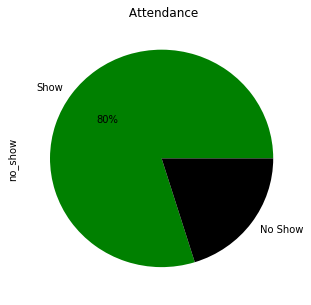

In [69]:
colors = ['green', 'black']
labels = 'Show', 'No Show'
df['no_show'].value_counts().plot(kind='pie', 
                                  title= ' Attendance',
                                  labels=labels,
                                  colors=colors,
                                  autopct='%1.0f%%',
                                  figsize=(5,5));

<a id='eda'></a>
## Exploratory Data Analysis


### Research Question 1 (Are the Gender will effect on the numbers of no-show patients?)

> We will see here if the Gender will give us any sign to be related to no-shown or not 



## Reconnoitring The Column of Gender

In [12]:
# Use this, and more code cells, to explore your data. Don't forget to add
#   Markdown cells to document your observations and findings.
df.gender.value_counts()

F    71840
M    38687
Name: gender, dtype: int64

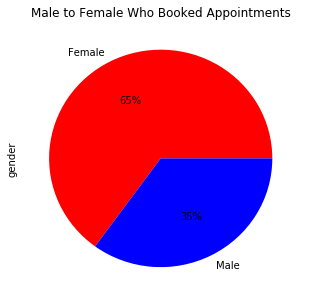

In [15]:
colors = ['red', 'blue']
labels = ['Female', 'Male']
df.gender.value_counts().plot(kind='pie', autopct='%1.0f%%', title='Male to Female Who Booked Appointments R',
                              labels=labels, colors=colors, figsize=(5,5));



## As we see the 65% of patients are Female in booking appointments which is greater than Male, we will see comparison between each of them with the percentage from total number.

In [16]:
gender_counts = df.groupby(['gender', 'no_show']).count()['age']
gender_counts

gender  no_show
F       No         57246
        Yes        14594
M       No         30962
        Yes         7725
Name: age, dtype: int64

In [17]:
gender_totals = df.groupby('gender').count()['age']
gender_totals

gender
F    71840
M    38687
Name: age, dtype: int64

In [18]:
female_proportions = gender_counts['F'] / gender_totals['F']
female_proportions

no_show
No     0.796854
Yes    0.203146
Name: age, dtype: float64

In [19]:
male_proportions = gender_counts['M'] / gender_totals['M']
male_proportions

no_show
No     0.800321
Yes    0.199679
Name: age, dtype: float64

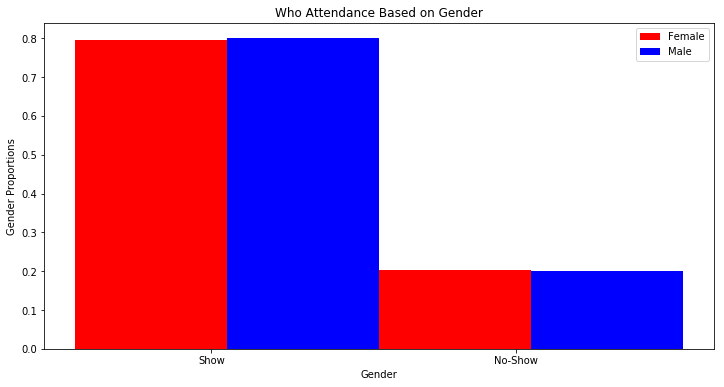

In [20]:
ind = np.arange(len(female_proportions)) # the label locations
width = 0.5 # width between the bars
plt.figure(figsize=(12,6))
female_bars = plt.bar(ind, female_proportions, width, color='red', label='Female')
male_bars = plt.bar(ind + width, male_proportions, width, color='blue', label='Male')
plt.ylabel('Gender Proportions')
plt.xlabel('Gender')
plt.title('Who Attendance Based on Gender')
locations = ind + width / 2.5
labels = ['Show', 'No-Show']
plt.xticks(locations,labels)
plt.legend();

## We can say after we see this data clearly no any relation between the Gander and no-shown at all.

### Research Question 2  (Can be the Medical disabilities have any impact on the numbers of no-show patients?)

> We will see here if the Medical disabilities will give us any sign to be related to no-shown or not

## Reconnoitring Medical Disabilities Data Columns


In [ ]:
# Continue to explore the data to address your additional research
#   questions. Add more headers as needed if you have more questions to
#   investigate.


In [21]:
df.hypertension.unique()

array([1, 0])

In [22]:
df.diabetes.unique()

array([0, 1])

In [23]:
df.alcoholism.unique()

array([0, 1])

In [24]:
df.handcap.unique()

array([0, 1, 2, 3, 4])

In [42]:
noshow_totals = dfnoshow.no_show.count() 
noshow_totals

22319

In [25]:
df.groupby('no_show')[['hypertension', 'diabetes', 'alcoholism']].mean()

,hypertension,diabetes,alcoholism
no_show,,,
No,0.204392,0.073837,0.030417
Yes,0.169004,0.064071,0.030333


In [37]:
dfnoshow = df[df['no_show'] == 'Yes']
dfnoshow.head()

,gender,scheduled_day,appointment_day,age,neighbourhood,scholarship,hypertension,diabetes,alcoholism,handcap,sms_received,no_show
6,F,2016-04-27T15:05:12Z,2016-04-29T00:00:00Z,23,GOIABEIRAS,0,0,0,0,0,0,Yes
7,F,2016-04-27T15:39:58Z,2016-04-29T00:00:00Z,39,GOIABEIRAS,0,0,0,0,0,0,Yes
11,M,2016-04-26T08:44:12Z,2016-04-29T00:00:00Z,29,NOVA PALESTINA,0,0,0,0,0,1,Yes
17,F,2016-04-28T09:28:57Z,2016-04-29T00:00:00Z,40,CONQUISTA,1,0,0,0,0,0,Yes
20,F,2016-04-27T07:51:14Z,2016-04-29T00:00:00Z,30,NOVA PALESTINA,0,0,0,0,0,0,Yes


In [38]:
hypertension_sum = dfnoshow.hypertension.sum()
diabetes_sum = dfnoshow.diabetes.sum()
alcoholism_sum = dfnoshow.alcoholism.sum()

In [43]:
hypertension_sum_ratio = hypertension_sum / noshow_totals
diabetes_sum_ratio = diabetes_sum / noshow_totals
alcoholism_sum_ratio = alcoholism_sum / noshow_totals

In [44]:
noshow_condition_ratios = [hypertension_sum_ratio, diabetes_sum_ratio, alcoholism_sum_ratio]
noshow_condition_ratios

[0.16900398763385457, 0.064070970921636272, 0.030332900219543886]

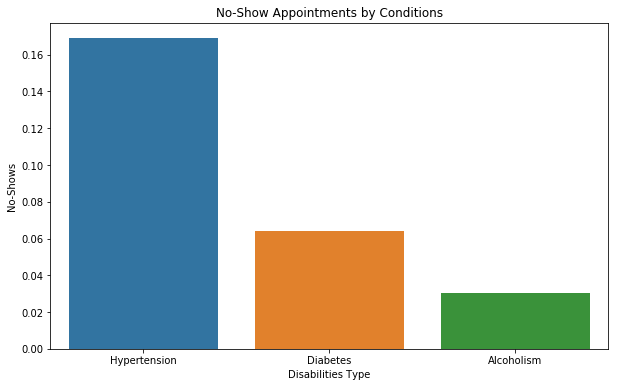

In [47]:
plt.figure(figsize=(10,6))
ax = sns.barplot(x=['Hypertension', 'Diabetes', 'Alcoholism'], y=noshow_condition_ratios)

ax.set(title="No-Show Appointments by Conditions",
       ylabel='No-Shows',
       xlabel='Disabilities Type');

## Here we can find very useful sing as we have almost 17% which have Hypertension shown more compared with Alcoholism and Diabetes. 

<a id='conclusions'></a>
## Conclusions

> Findings:

> 1- no-showed patients is around 20% from total patients appointments.

> 2- 65% of patients are Female in booking appointments which is greater than Male, we will see comparison between each of them with the percentage from total number no any relation between the Gander and no-shown at all.

> Once we comparing hypertension, diabetes and alcoholism we found the alcoholism had only 3% to overall no-show, but hypertension patients more than 17%

> Limitations

> 1-same columns used categorical data its very difficult to analyze.

> 2-It was some incorrect data that was removed from the analysis and some spelling mistake on it.

> 3- They are repeat patients who have been there before would provide important insights we need to sort data for every patients without repeated everything again.



In [ ]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])